In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt
from scipy.special import softmax

from tqdm import tqdm

from battleship.fast_sampler import FastSampler
from battleship.board import Board

In [4]:
# Configure Seaborn for high definition scientific plots
# sns.set_context('paper')
# sns.set_style('whitegrid')
# sns.set_palette('colorblind')

# Configure seaborn for retina display
%config InlineBackend.figure_format = 'retina'

In [5]:
SHIP_LENGTHS = range(2, 6)
SHIP_LABELS = ["R", "G", "P", "O"]

BOARD_EMPTY = Board(np.full((8, 8), -1))
SEED = 123

In [ ]:
BOARD_EMPTY

In [ ]:
# Generate the target board

sampler = FastSampler(
    board=BOARD_EMPTY, ship_lengths=SHIP_LENGTHS, ship_labels=SHIP_LABELS, seed=SEED
)

BOARD_TARGET = sampler.populate_board()
BOARD_TARGET

In [53]:
# A baseline agent that computes a posterior over the visible board in order to make a move
def check_win(board_agent: Board, board_target: Board):
    """Checks whether all ship tiles have been revealed.

    Ship tiles are all tiles with a positive integer value.
    """
    return np.all(board_agent.board[board_target.board > 0] > 0)


def simulate_game(
    board_start: Board,
    board_target: Board,
    n_samples: int = 1000,
    seed: int = 123,
    show_board: bool = False,
):
    rng = np.random.default_rng(seed)

    board_agent = Board(board_start.board.copy())

    moves = []

    while not check_win(board_agent, board_target):
        # Compute the posterior over the board
        sampler = FastSampler(
            board=board_agent,
            ship_lengths=SHIP_LENGTHS,
            ship_labels=SHIP_LABELS,
            seed=SEED,
        )

        # Compute posterior (return raw counts)
        posterior = sampler.compute_posterior(n_samples=n_samples, normalize=False)

        if show_board:
            display(Board._to_figure(posterior, mode="heatmap"))

        # Set the posterior to -inf for revealed tiles
        posterior = posterior.astype(float)
        posterior[board_agent.board != -1] = -np.inf

        # Apply softmax to the posterior
        posterior = softmax(posterior)

        # Sample a tile from the posterior
        tile_idx = rng.choice(
            np.arange(board_agent.size**2), p=posterior.flatten()
        )

        # Convert the tile index back to a 2D index
        tile = np.unravel_index(tile_idx, board_agent.board.shape)

        if tile in moves:
            raise ValueError(f"Encountered repeated move: {tile}")
        if board_agent.board[tile] != -1:
            raise ValueError(f"Tile already revealed: {tile}")

        moves.append(tile)

        # Reveal the sampled tile
        board_agent.board[tile] = board_target.board[tile]

        if show_board:
            display(board_agent)

    if show_board:
        print(f"Finished in {len(moves)} moves!")

    return moves

In [ ]:
moves = simulate_game(BOARD_EMPTY, BOARD_TARGET, seed=SEED, n_samples=10000, show_board=True)

In [54]:
# Compute the distribution of the number of moves required to finish the game for different boards and sample sizes

SEED_GENERATOR = 123
SEED_SIMULATOR = 456
N_BOARDS = 100
N_SAMPLES = [10, 100, 1000]
# N_SAMPLES = [10]

sampler = FastSampler(
    board=BOARD_EMPTY,
    ship_lengths=SHIP_LENGTHS,
    ship_labels=SHIP_LABELS,
    seed=SEED_GENERATOR,
)

# Generate test boards
print(f"Generating {N_BOARDS} target boards...")
target_boards = []
for _ in range(N_BOARDS):
    board_target = sampler.populate_board()
    target_boards.append(board_target)

# Simulate games
print(f"Simulating games...")
results = []
for n_samples in N_SAMPLES:
    print(f"n_samples={n_samples}")
    for board_id, target_board in tqdm(enumerate(target_boards), total=len(target_boards)):
        moves = simulate_game(
            BOARD_EMPTY, target_board, n_samples=n_samples, seed=SEED_SIMULATOR
        )
        results.append(
            {
                "board_id": board_id,
                "n_samples": n_samples,
                "n_moves": len(moves),
            }
        )

Generating 100 target boards...
Simulating games...
n_samples=10


 47%|████▋     | 47/100 [00:02<00:02, 24.12it/s]

100%|██████████| 100/100 [00:04<00:00, 23.37it/s]


n_samples=100


100%|██████████| 100/100 [00:18<00:00,  5.29it/s]


n_samples=1000


100%|██████████| 100/100 [02:35<00:00,  1.55s/it]


In [71]:
# Compute the mean of each distribution
results_df = pd.DataFrame(results)
results_df.groupby("n_samples")["n_moves"].agg(
    [
        "min",
        "max",
        "median",
        "mean",
        pd.Series.mode,
        "std",
    ]
)

,min,max,median,mean,mode,std
n_samples,,,,,,
10,22,49,36.0,35.48,36,6.414126
100,22,47,32.0,33.31,32,6.126107
1000,20,45,31.0,31.86,26,6.206904


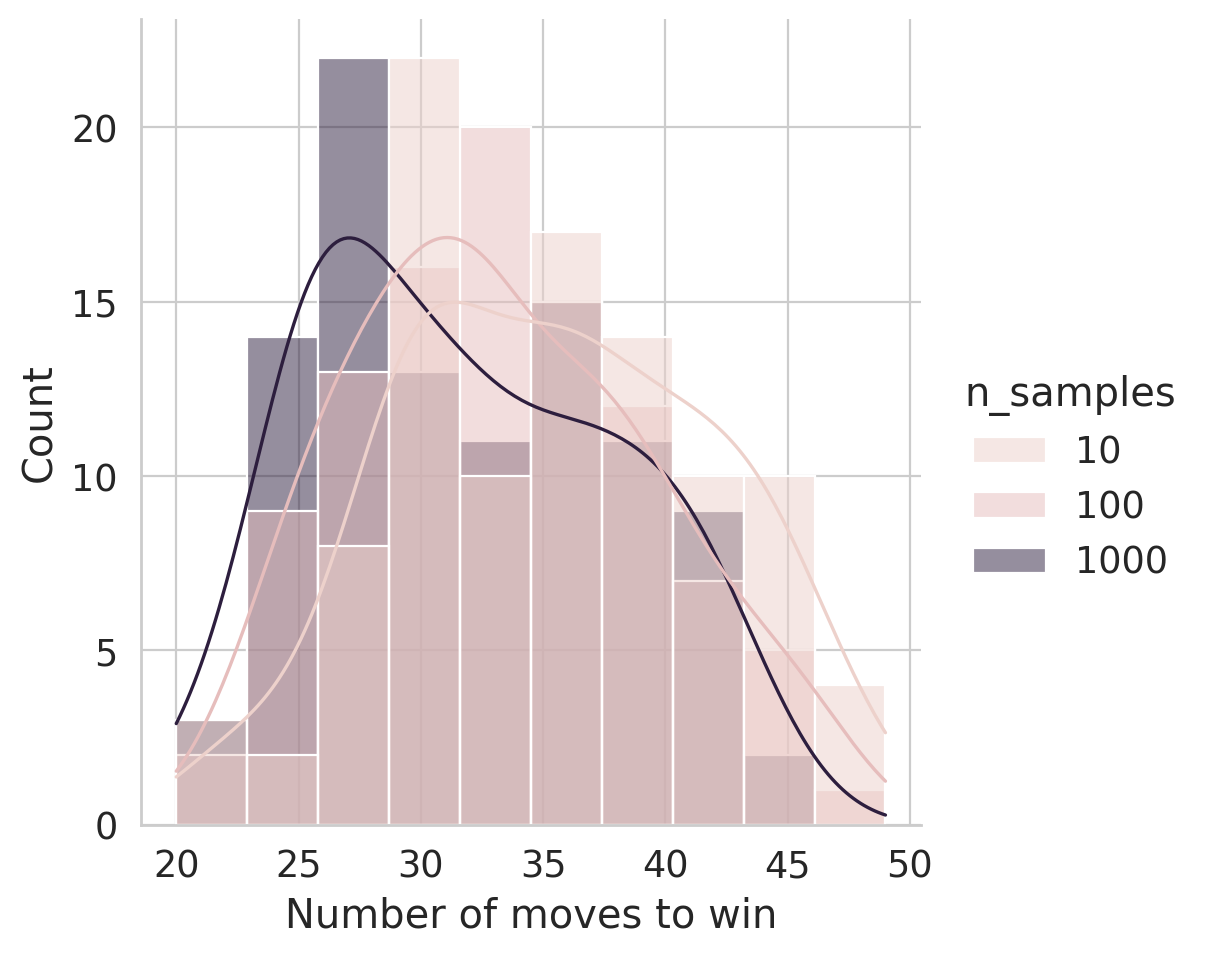

In [58]:
with sns.plotting_context("paper", font_scale=1.5), sns.axes_style("whitegrid"):

    # combined histogram and kde
    sns.displot(data=pd.DataFrame(results), x="n_moves", hue="n_samples", kind="hist", stat="count", common_norm=False, kde=True)

    # change x-label
    plt.xlabel("Number of moves to win")

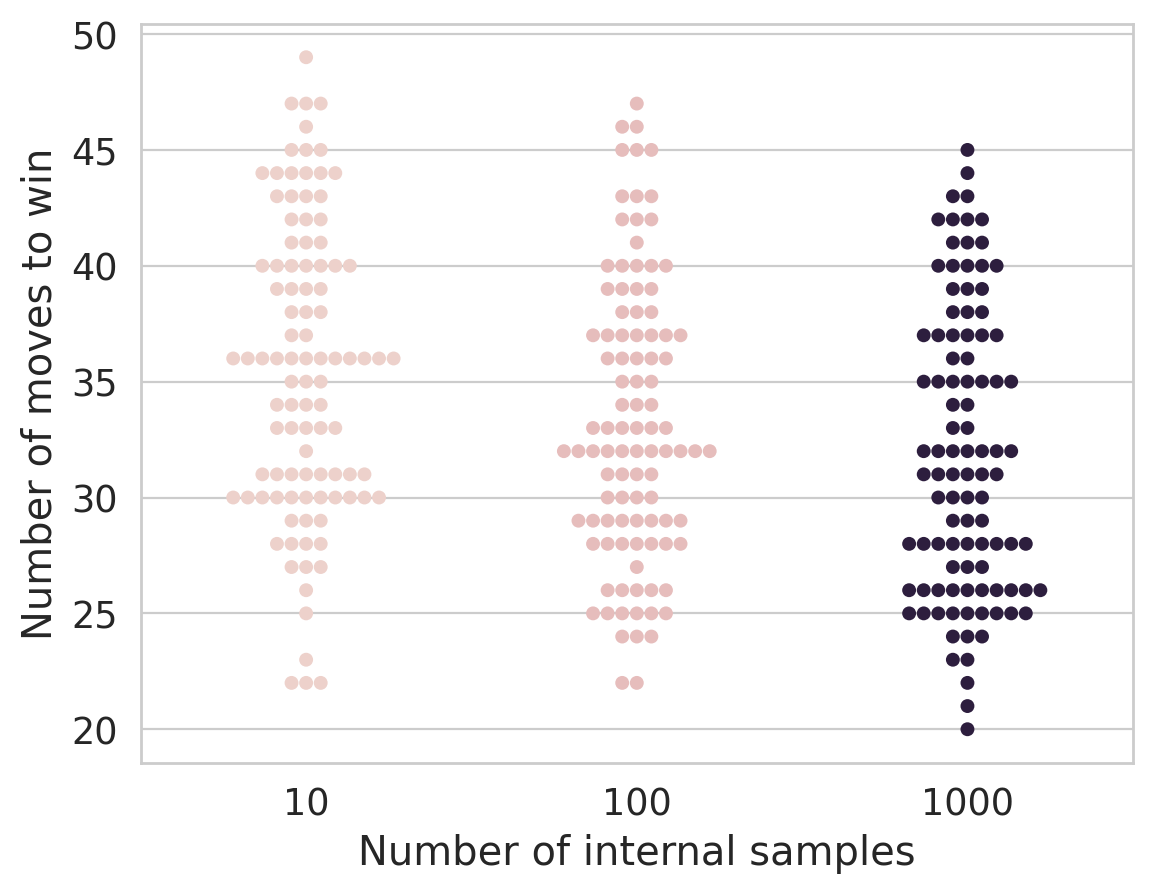

In [82]:
with sns.plotting_context("paper", font_scale=1.5), sns.axes_style("whitegrid"):

    # combined histogram and kde
    sns.swarmplot(
        data=pd.DataFrame(results),
        x="n_samples",
        y="n_moves",
        hue="n_samples",
        legend=False,
    )

plt.xlabel("Number of internal samples");
plt.ylabel("Number of moves to win");